In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing import sequence
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout
from keras import initializers
from sklearn.model_selection import train_test_split
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras import initializers
import gc

Using TensorFlow backend.


In [10]:
# function for clearning train data!
# + remove IP
def clear_data(df, option):
    
    df['click_time'] = pd.to_datetime(df['click_time'])
    
    bin_day = np.array([0,4,5,6])
    df['weekday'] = df['click_time'].dt.dayofweek
    df['weekday'] = np.digitize(df['weekday'],bin_day)
    
    bin_hour = np.array([0,1,9,13,18,22,24])
    df['hour'] = df['click_time'].dt.hour
    df['hour2'] = np.digitize(df['hour'],bin_day)
    
    bin_ip = np.array([0, 150000,1000000])
    df['ip'] = np.digitize(df['ip'],bin_ip)
    
    df = df.drop(columns=['click_time'])
    if (option == 'train'):
        y = df['is_attributed']
        df = df.drop(columns=['is_attributed','attributed_time'], axis=1)
        return df, y
    elif (option == 'test'):
        sub_id = df['click_id']
        df = df.drop(columns=['click_id'], axis=1)
        return df, sub_id
    
    

In [3]:
print('load 10% training sample + train/val')
df = pd.read_csv('train_sampling10.csv')
df, y = clear_data(df,'train')
x_train, x_val, y_train, y_val = train_test_split(df,y,test_size=0.1)

x_train= x_train.drop(columns=['Unnamed: 0'])
x_val= x_val.drop(columns=['Unnamed: 0'])

print(x_train.head(2))
print(x_val.head(2))
print(y_train.head(2))
print(y_val.head(2))
del df, y; gc.collect()

load 10% training sample + train/val
        ip  app  device  os  channel  weekday  hour  hour2
284161   1   12       1  13      259        1     1      1
132533   1   14       1  19      439        1    17      4
         ip  app  device  os  channel  weekday  hour  hour2
259870    2   21       1  27      128        1    16      4
1886056   1    1       2   9      178        1    12      4
284161    0
132533    0
Name: is_attributed, dtype: int64
259870     0
1886056    0
Name: is_attributed, dtype: int64


61

In [4]:
print("define NN")
model = Sequential()
# give options of Dense, 
# https://github.com/keras-team/keras/blob/befbdaa076eedb2787ce340b1a5b4accf93d123d/examples/mnist_irnn.py
# RNN?? next try!
kernel_init=initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)

# structure of NN: 16 - 64
model.add(Dense(16,activation='relu',kernel_initializer=kernel_init,
                bias_initializer='zeros',input_shape=(x_train.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(64,kernel_initializer=kernel_init,
                bias_initializer='zeros',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(32,kernel_initializer=kernel_init,
                bias_initializer='zeros',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(16,kernel_initializer=kernel_init,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(1,activation='sigmoid'))


define NN


In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                144       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                1088      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
__________

In [6]:
gc.collect()
print("start training")
# control NN's option
batch_size = 256
epoch = 10
# class_weight = {0:0.1, 1:0.9}
class_weight = {0:0.5, 1:0.5}

exp_decay = lambda init, fin, steps: (init/fin)**(1/(steps-1)) - 1
steps = int(len(list(x_train)[0]) / batch_size) * epoch
lr_init, lr_fin = 0.0015, 0.0005 # lr=0.001 default 
lr_decay = exp_decay(lr_init, lr_fin, steps)
optimizer_adam = optimizers.Adam(lr=0.002, decay=lr_decay)

######################
# compile + training
model.compile(loss='binary_crossentropy',optimizer=optimizer_adam,metrics=['accuracy'])
model.fit(x_train,y_train,batch_size = batch_size,epochs=epoch,validation_data=(x_val,y_val),class_weight=class_weight)

del x_train, y_train; gc.collect()

start training
Train on 3701196 samples, validate on 411244 samples
Epoch 1/10
3701196/3701196 [==============================] - 200s 54us/step - loss: 0.1013 - acc: 0.9323 - val_loss: 0.1800 - val_acc: 0.9351
Epoch 2/10
3701196/3701196 [==============================] - 200s 54us/step - loss: 0.0909 - acc: 0.9417 - val_loss: 0.1686 - val_acc: 0.9466
Epoch 3/10
3701196/3701196 [==============================] - 201s 54us/step - loss: 0.0896 - acc: 0.9430 - val_loss: 0.1583 - val_acc: 0.9518
Epoch 4/10
3701196/3701196 [==============================] - 204s 55us/step - loss: 0.0889 - acc: 0.9437 - val_loss: 0.1618 - val_acc: 0.9480
Epoch 5/10
3701196/3701196 [==============================] - 218s 59us/step - loss: 0.0881 - acc: 0.9445 - val_loss: 0.1627 - val_acc: 0.9493
Epoch 6/10
3701196/3701196 [==============================] - 224s 61us/step - loss: 0.0879 - acc: 0.9448 - val_loss: 0.1590 - val_acc: 0.9544
Epoch 7/10
3701196/3701196 [==============================] - 216s 58us/st

80

[[ 0.14138213]
 [ 0.01163691]
 [ 0.01581446]
 ..., 
 [ 0.01901147]
 [ 0.05291112]
 [ 0.01189508]]
((411244, 1), (411244,))
         ip  app  device  os  channel  weekday  hour  hour2
259870    2   21       1  27      128        1    16      4
1886056   1    1       2   9      178        1    12      4
1789344   2    1       1  23      134        1    13      4
3140192   1   29       1  19      213        1     5      3
2989038   1    2       1  37      237        1    13      4


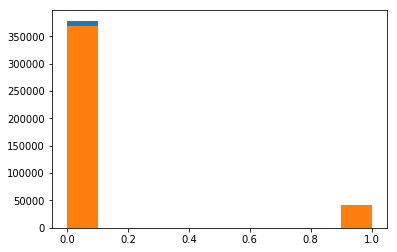

In [7]:
kk = model.predict(x_val,batch_size=batch_size,verbose=2)
print(kk)

print(kk.shape,y_val.shape)
plt.hist(np.round(kk))
plt.hist(y_val)
print(x_val.head())


In [8]:
print("Saved model to disk")
json_string = model.to_json()
with open("saved_models/model3.json", "w") as json_file:
    json_file.write(json_string)
model.save_weights('saved_models/weights3.h5')

Saved model to disk


In [11]:
print("predicting")
df_sub = pd.DataFrame()
df_sub_01 = pd.DataFrame()
ttest = pd.read_csv('test.csv')
print("finish read test data")

ttest, idd = clear_data(ttest,'test')
df_sub['click_id'] = idd.astype('int32')
df_sub['is_attributed'] = model.predict(ttest,batch_size=batch_size,verbose=2)


predicting
finish read test data


check result
           click_id  is_attributed
count  1.879047e+07   1.879047e+07
mean   9.395234e+06   2.047682e-01
std    5.424341e+06   1.472872e-01
min    0.000000e+00   8.263137e-03
25%    4.697617e+06   1.101825e-01
50%    9.395234e+06   1.617264e-01
75%    1.409285e+07   2.528632e-01
max    1.879047e+07   9.651867e-01


(array([ 3624653.,  7825188.,  4521555.,  1565078.,   390272.,   102682.,
          194948.,   193675.,   156932.,   215486.]),
 array([ 0.00826314,  0.10395549,  0.19964784,  0.29534019,  0.39103254,
         0.4867249 ,  0.58241725,  0.6781096 ,  0.77380195,  0.8694943 ,
         0.96518666]),
 <a list of 10 Patch objects>)

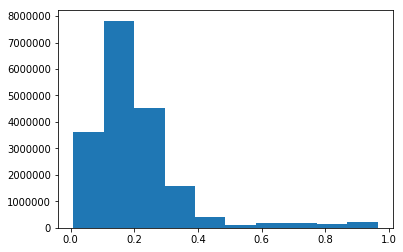

In [12]:
print("check result")
print(df_sub.describe())
plt.hist(df_sub['is_attributed'])

In [13]:
print("save the result")
df_sub.to_csv('sub_result/result_code4_2_sample10.csv',index=False)



save the result


(array([ 17935913.,         0.,         0.,         0.,         0.,
                0.,         0.,         0.,         0.,    854556.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

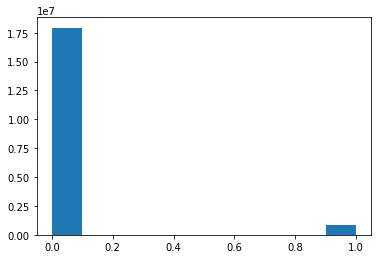

In [14]:
plt.hist(np.round(df_sub['is_attributed']))